In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
import newcmaps

import numpy as np
import healpy as hp
import scipy
from scipy import special as ss
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import math,glob,sys
import NX01_bayesutils as bu
import NX01_utils as utils

import AnisCoefficients_pix as pixAnis
import plot

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

# IPTA MDC injection

## Injected map

In [2]:
clm_inj = np.load('nanogravTests_pointAnis.npy')

In [3]:
clm_inj

array([ 3.5449077 , -0.58004952,  0.5000429 ,  0.38757574, -0.58507975,
       -0.75636711,  0.00869584,  0.50537718, -0.24235522, -0.10852881,
       -0.90302081, -0.38019683, -0.49805607,  0.25403584, -0.37405437,
       -0.54562877,  0.33893872, -0.18974301, -0.69957401,  0.28682588,
       -0.58943123, -0.19167782, -0.28981041, -0.95390645, -0.33894172])

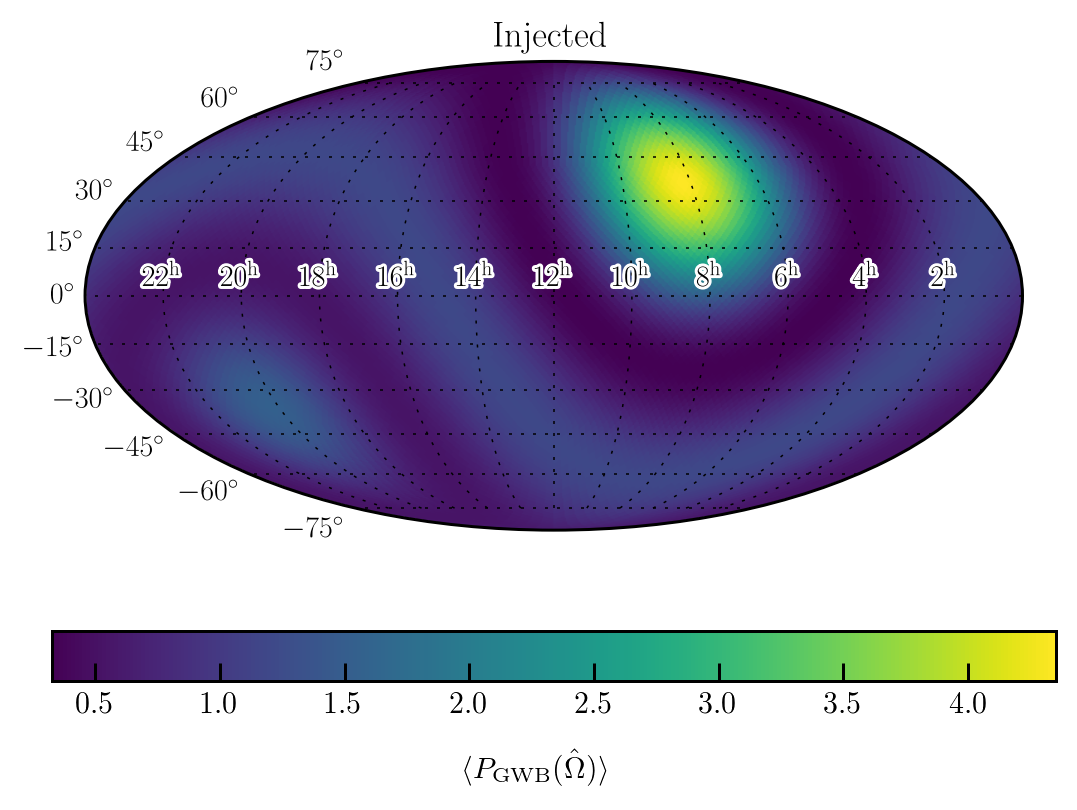

In [5]:
map_inj = bu.makeSkyMap(clm_inj[1:],lmax=4,nside=32,cmap=newcmaps.viridis)
plt.title('Injected')
#plt.savefig('nanoAnisTests_pointInj.png',bbox_inches='tight',dpi=400)

## Spherical harmonic analysis: produce posterior averaged skymap

In [6]:
dirnames = sorted(glob.glob('chains_iptamdc_mockanishotspot_dataset*'))

In [7]:
dirnames

['chains_iptamdc_mockanishotspot_dataset0',
 'chains_iptamdc_mockanishotspot_dataset1',
 'chains_iptamdc_mockanishotspot_dataset2',
 'chains_iptamdc_mockanishotspot_dataset3',
 'chains_iptamdc_mockanishotspot_dataset4']

In [8]:
clm_chain = []
for ii,name in enumerate(dirnames):
    try:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    except:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [19]:
LMAX = 4

In [20]:
#### Making skymaps out of all clm samples ####

hchain = np.zeros((len(clm_chain[0]),hp.nside2npix(nside=32)))
for ii in range(len(clm_chain[0])):
    sample = np.append(2.0*np.sqrt(np.pi), clm_chain[0][ii,-4-(LMAX+1)**2+1:-4])
    hchain[ii,:] = pixAnis.mapFromClm_fast(sample,nside=32)

    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(clm_chain[0]))
    sys.stdout.flush()

55400 of 55400


In [21]:
h_mean = np.mean(hchain,axis=0)
h_std = np.std(hchain,axis=0)

In [28]:
ind_max = np.argmax(clm_chain[0][:,-4])

In [29]:
ind_max

23463

In [30]:
hMAP = pixAnis.mapFromClm_fast(np.append(2.0*np.sqrt(np.pi), clm_chain[0][ind_max,-4-(LMAX+1)**2+1:-4]),nside=32)

In [25]:
h_conf = np.zeros_like(h_std)
for ii in range(len(h_conf)):
    low, up = bu.confinterval(hchain[:,ii],sigma=0.68,onesided=False)
    h_conf[ii] = up - low
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(h_conf))
    sys.stdout.flush()

12288 of 12288


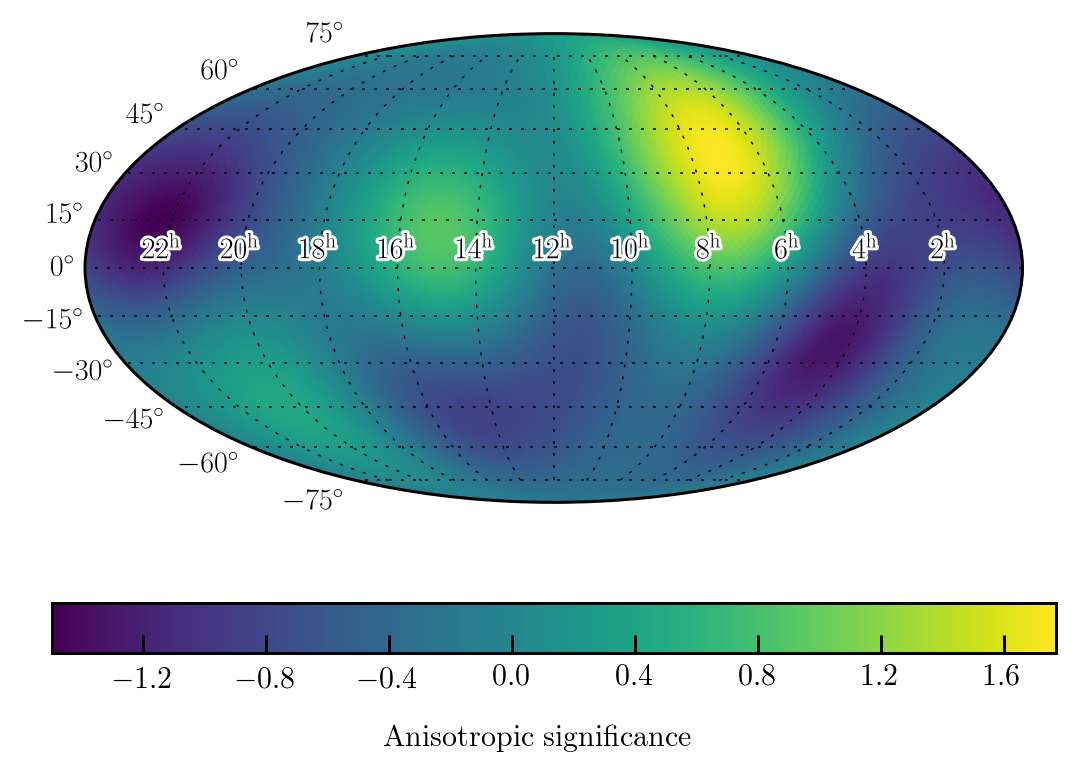

In [33]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap((hMAP - 1.0)/h_conf, cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle('Anisotropic significance', y=0.1)

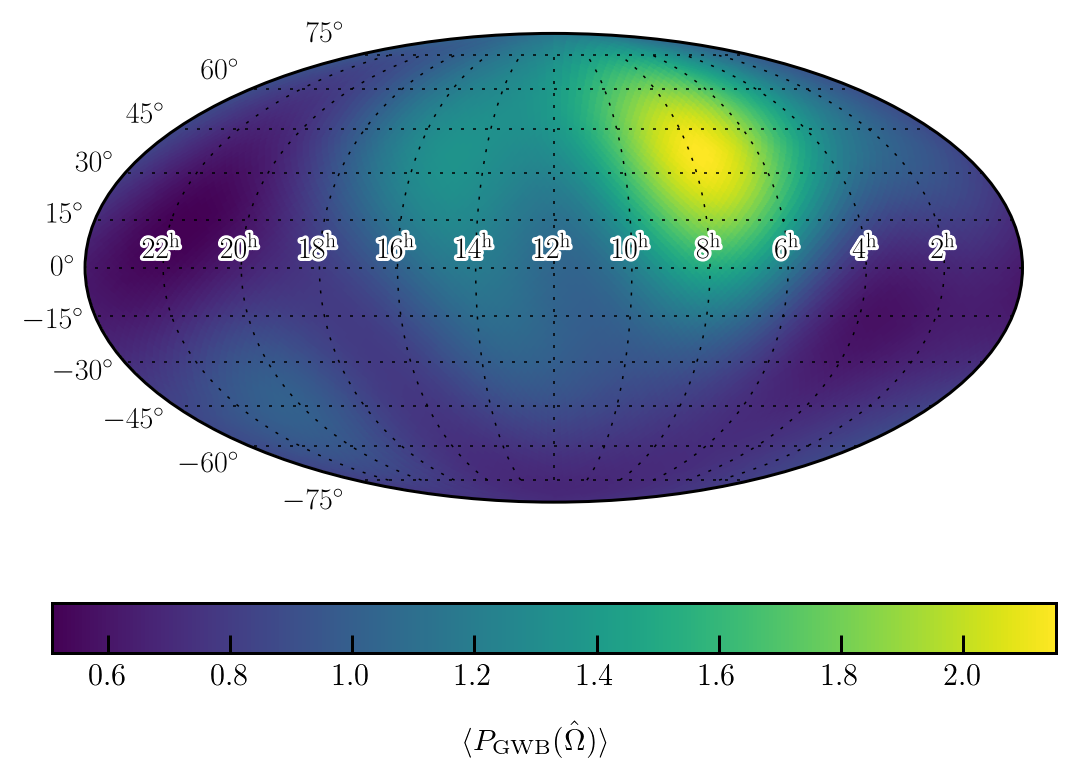

In [23]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(h_mean, cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle(r'$\langle P_{\mathrm{GWB}}(\hat\Omega)\rangle$', y=0.1)

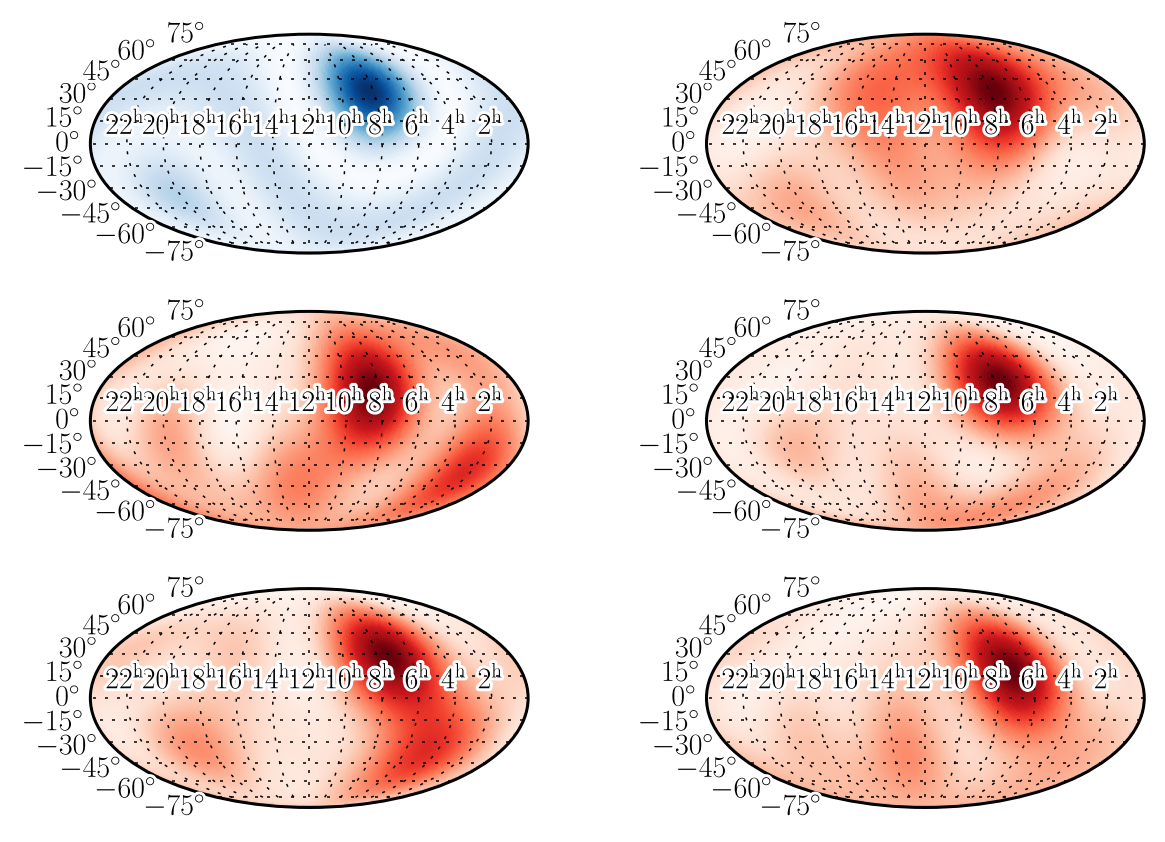

In [124]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

In [104]:
dipole_chain = np.loadtxt('./chains_iptamdc_mockanisdipole_dataset0/pta_gwbloguniform_Lmax1_noPhysPrior_gamVary_redFix_nmodes20/chain_1.txt')

In [105]:
dipole_chain.shape

(15400, 9)

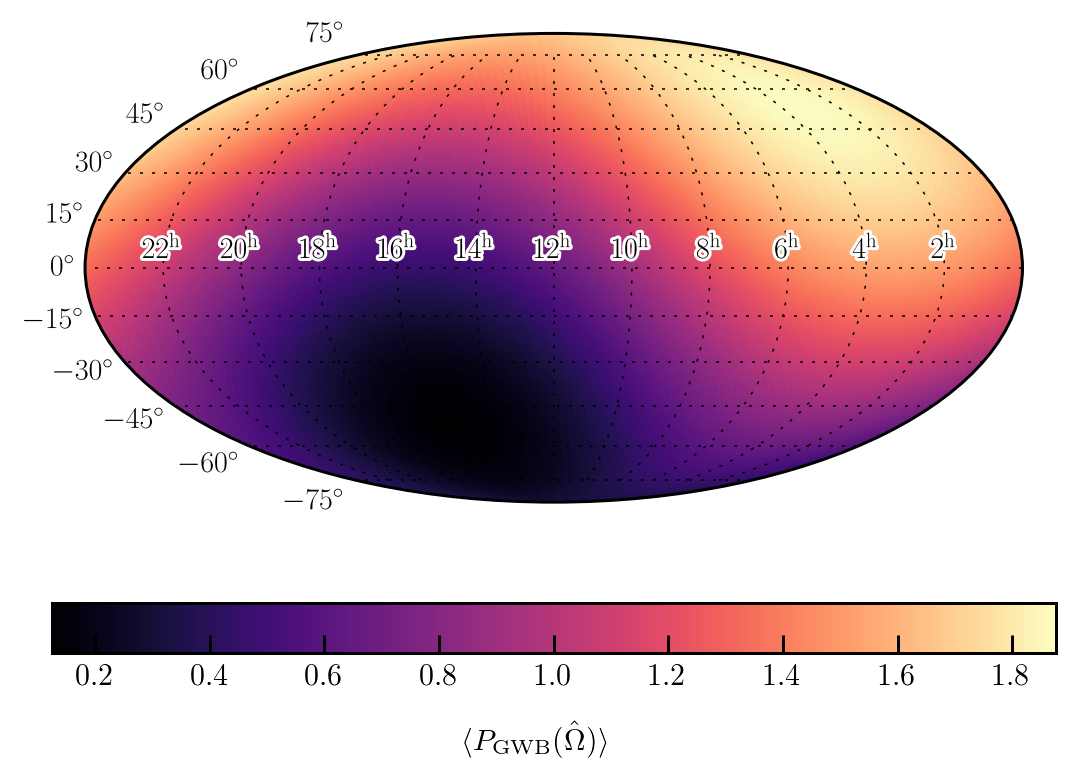

In [107]:
bu.makeSkyMap(dipole_chain[5000:,-4-(1+1)**2+1:-4],
              lmax=1, nside=32, 
              cmap=newcmaps.magma)

In [130]:
dirnames = sorted(glob.glob('chains_iptamdc_nanotype_mockanishotspot*'))

In [131]:
dirnames

['chains_iptamdc_nanotype_mockanishotspot',
 'chains_iptamdc_nanotype_mockanishotspot_dataset1',
 'chains_iptamdc_nanotype_mockanishotspot_dataset2',
 'chains_iptamdc_nanotype_mockanishotspot_dataset3',
 'chains_iptamdc_nanotype_mockanishotspot_dataset4']

In [139]:
nano_chain = []
for ii,name in enumerate(dirnames):
    #try:
    #    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    #except:
    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [140]:
LMAX = 4

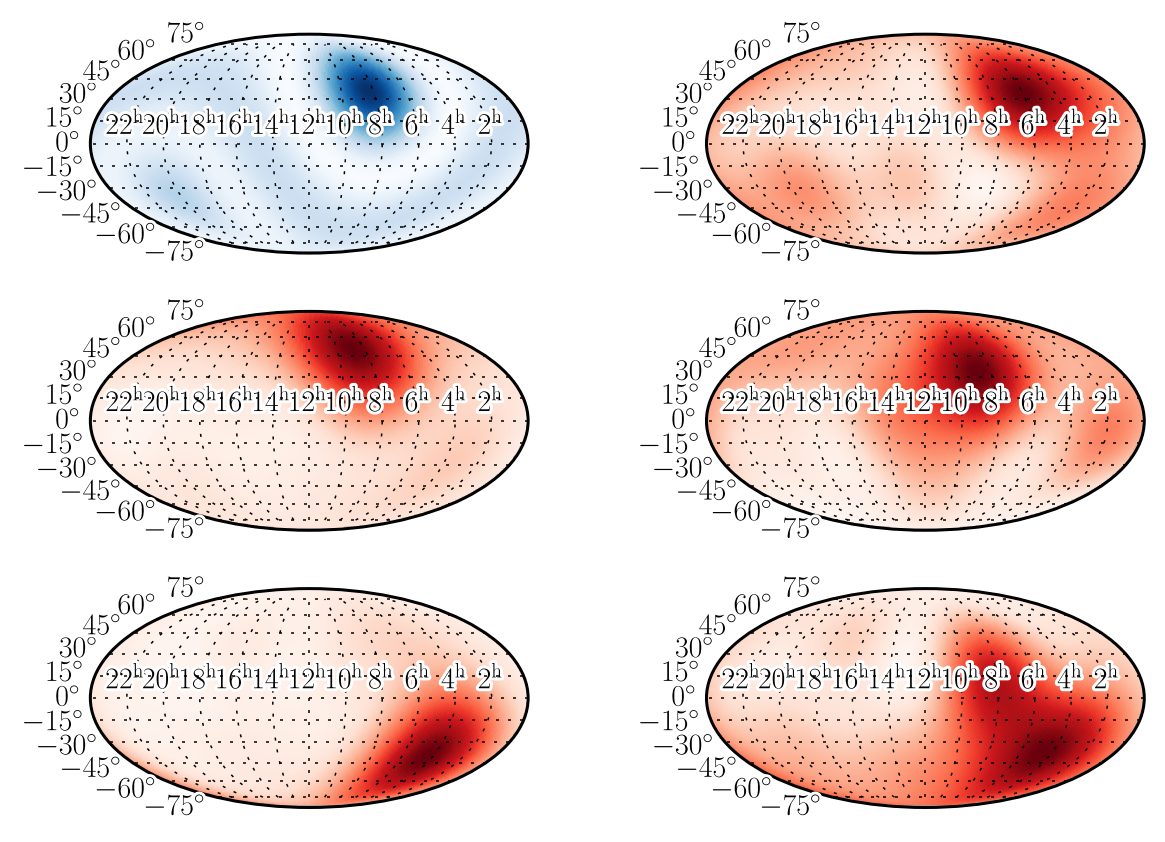

In [141]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

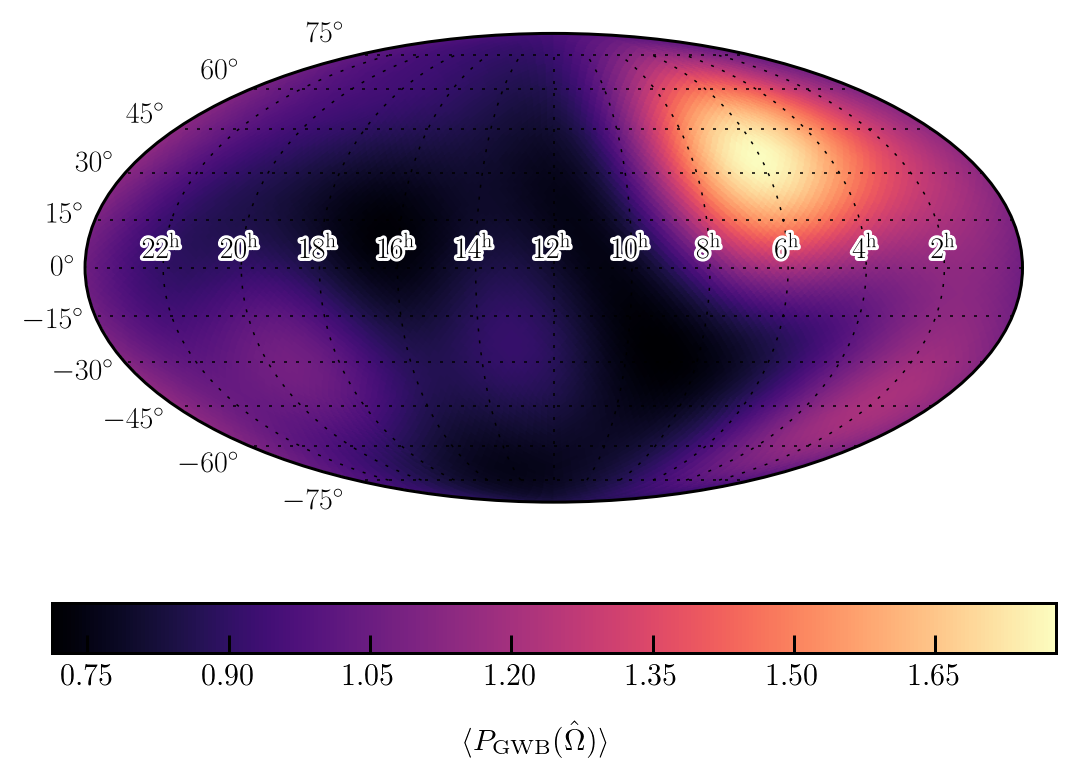

In [103]:
bu.makeSkyMap(nano_chain[1000:,-4-(4+1)**2+1:-4],
              lmax=4, nside=32, 
              cmap=newcmaps.magma)

In [34]:
nano_priorchain = np.loadtxt('./chains_nano9yr_anisConstLike/pta_constLike_gwbloguniform_Lmax5_gamVary_redloguniformpowerlaw_nmodes15/chain_1.0.txt',
                            usecols=np.arange(38,73))

/Users/staylor/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


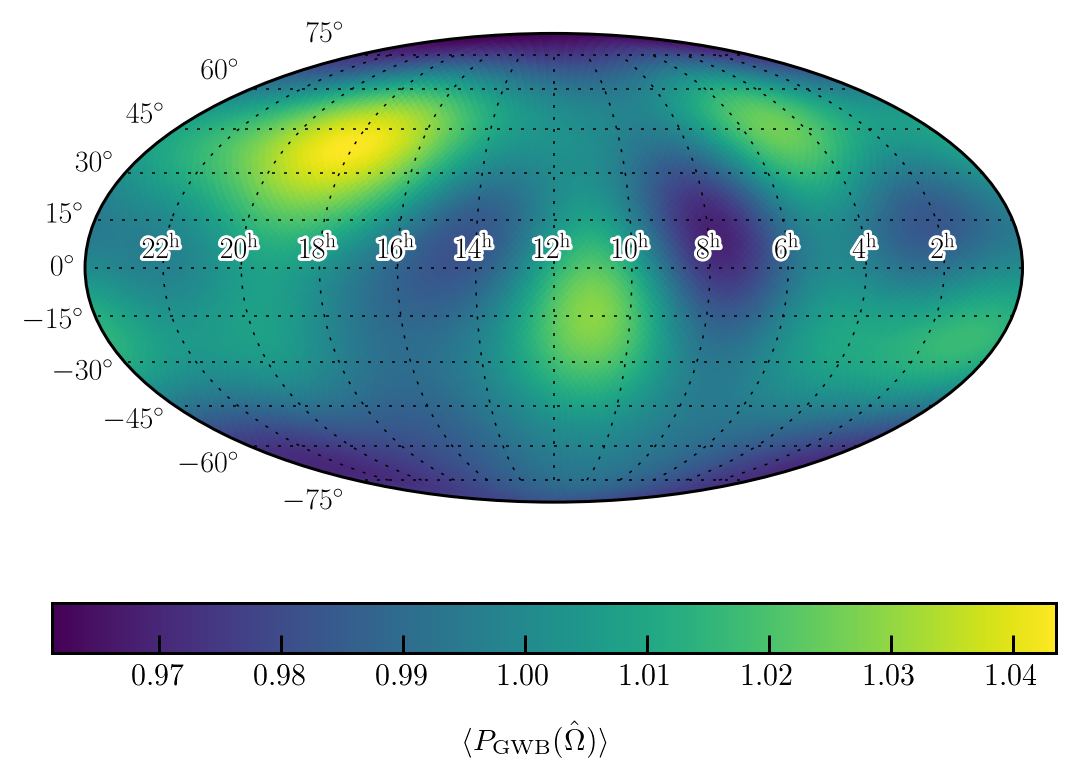

In [4]:
bu.makeSkyMap(nano_priorchain[50000:],
              lmax=5, nside=32, 
              cmap=newcmaps.viridis)
#plt.title('Constant likelihood (with phys. prior)')
#plt.savefig('nano9yr_lmax4physprior_constLike.pdf',bbox_inches='tight',dpi=400)

In [35]:
hchain_constLike = []
for ii in range(len(nano_priorchain[50000:])):
    sample = np.append(2.0*np.sqrt(np.pi), nano_priorchain[50000+ii,:])
    hchain_constLike.append(pixAnis.mapFromClm_fast(sample,nside=32))
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(nano_priorchain[50000:]))
    sys.stdout.flush()

98200 of 98200


In [37]:
hchain_constLike = np.array(hchain_constLike)

In [39]:
hmean_constLike = np.mean(hchain_constLike,axis=0)
hstd_constLike = np.std(hchain_constLike,axis=0)

In [17]:
#h_mean = np.mean(hchain,axis=0)
clmean = np.append(2.0*np.sqrt(np.pi), np.mean(nano_priorchain[50000:,:],axis=0))
h_mean = pixAnis.mapFromClm_fast(clmean,nside=32)

In [38]:
hconf_constLike = np.zeros_like(h_mean)
for ii in range(len(hconf_constLike)):
    low, up = bu.confinterval(hchain_constLike[:,ii],sigma=0.68,onesided=False)
    hconf_constLike[ii] = up - low
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(h_conf))
    sys.stdout.flush()

12288 of 12288


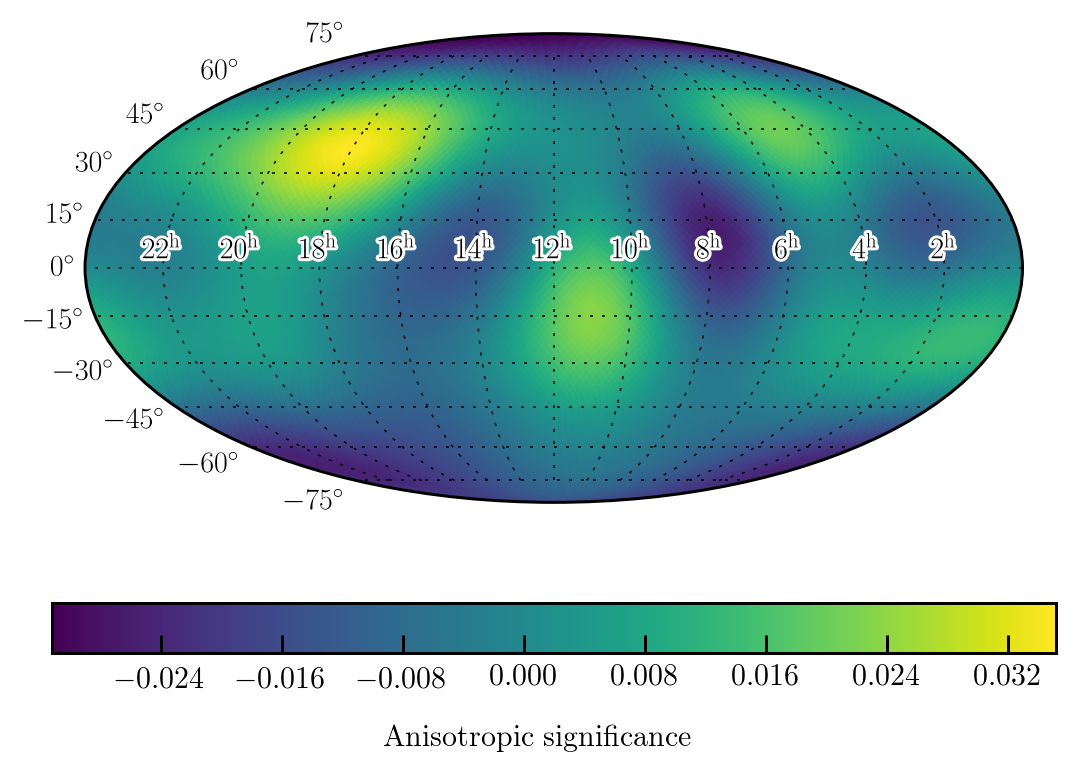

In [40]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap((hmean_constLike-1.0)/hconf_constLike,cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle('Anisotropic significance', y=0.1)

## Query-disk approach to anisotropy

In [3]:
chain_qdisk = np.loadtxt('./chains_iptamdc_mockanishotspot_dataset0/pta_gwbloguniform_gwDisk_gamVary_redFix_nmodes15/chain_1.txt')

In [12]:
burn = 1000
disk_map = []
for ii in range(len(chain_qdisk[burn:])):
    phi = chain_qdisk[burn+ii,2]
    costheta = chain_qdisk[burn+ii,3]
    theta = np.arccos(costheta)
    
    radius = chain_qdisk[burn+ii,4]
    wgt = chain_qdisk[burn+ii,5]
    
    vec = np.array([np.sin(theta)*np.cos(phi),
                    np.sin(theta)*np.sin(phi),
                    np.cos(theta)])
    
    m = np.ones(hp.nside2npix(nside=64))
    try:
        qd = hp.query_disc(nside=hp.npix2nside(len(m)),
                           vec=vec,
                           radius=radius)
        m[qd] *= 10.0**wgt
    except:
        m = np.ones(hp.nside2npix(nside=32))
    
    disk_map.append(m)
    
    clear_output()
    print '\r', phi, theta, radius, wgt
    print '\r', '{0} of {1}'.format(ii+1, len(chain_qdisk[burn:]))
    sys.stdout.flush()

1.93015765354 1.53822882273 0.405372776153 0.952828521526
11200 of 11200


In [13]:
mean_diskmap = np.mean(np.array(disk_map),axis=0)

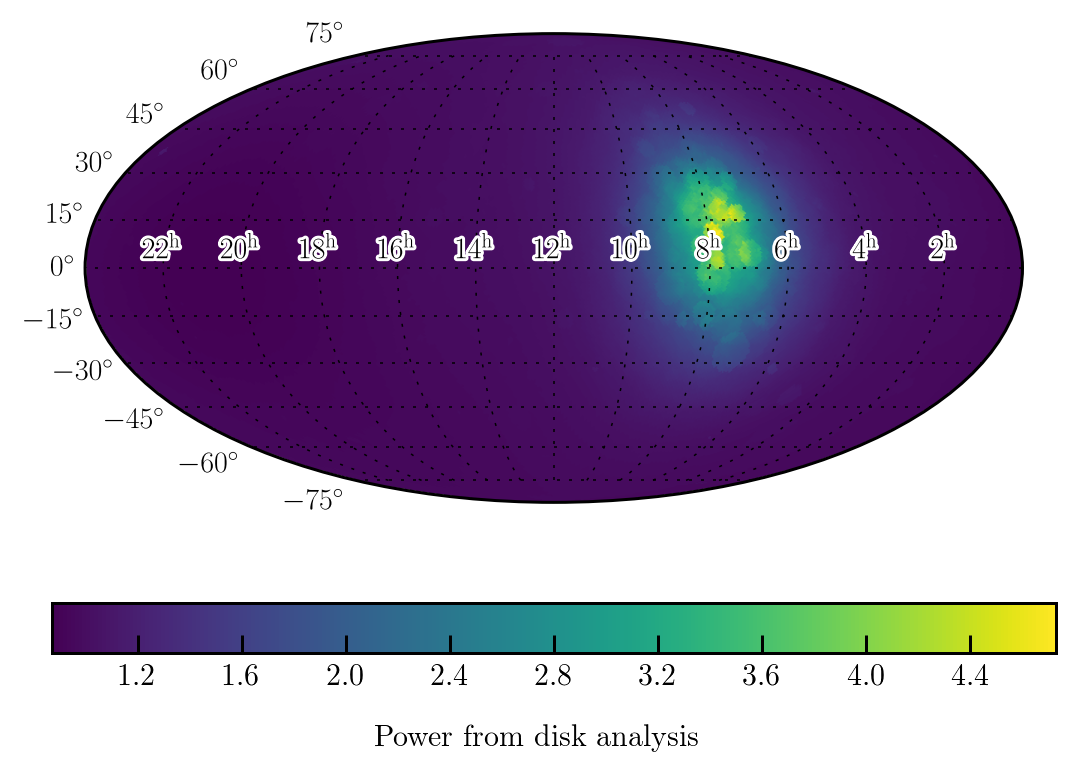

In [14]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(mean_diskmap,cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle('Power from disk analysis', y=0.1)

## Point-source anisotropy: produce posterior averaged skymap

In [5]:
pointSrc_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_pointSrc_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

Sigma is 68.754935 arcmin (0.020000 rad) 
-> fwhm is 161.905500 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


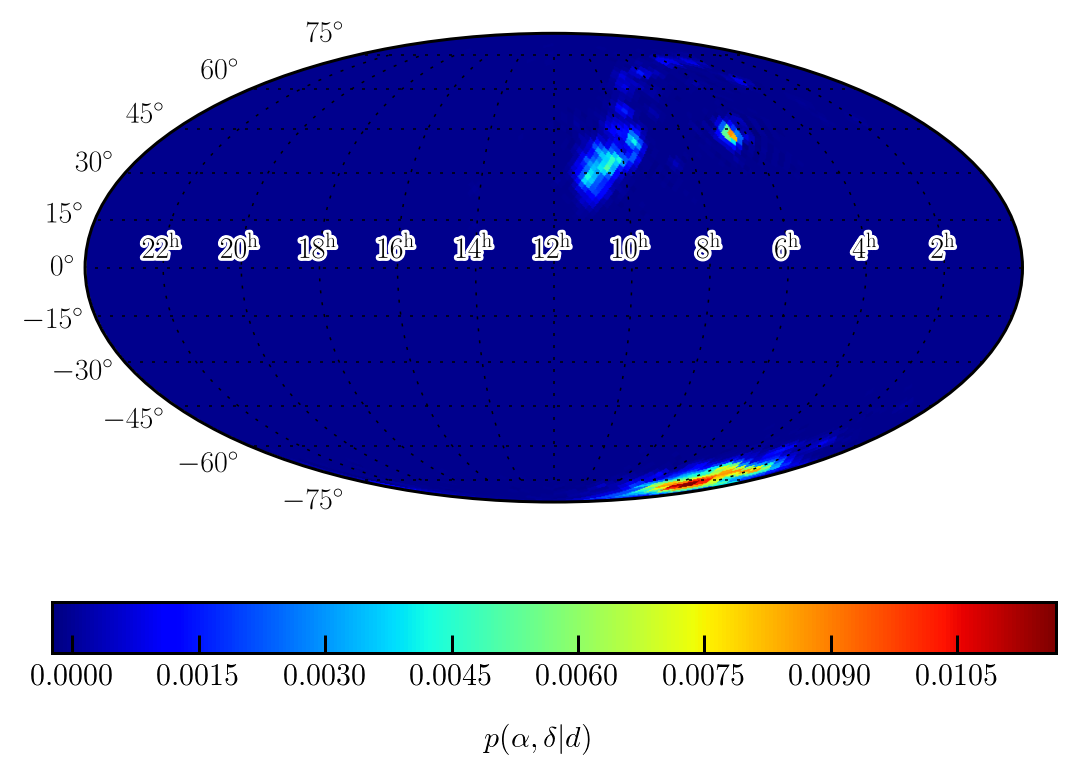

In [11]:
#map_point = bu.plotSkyMap(pointSrc_chain[:,74], np.pi/2. - np.arccos(pointSrc_chain[:,75]), nside=64, cmap='jet', outfile='skymap.pdf')
map_point = bu.plotSkyMap(pointSrc_chain[:,74] + np.pi, np.pi/2. - (np.pi - np.arccos(pointSrc_chain[:,75])), nside=32, cmap='jet', outfile='skymap.pdf')